# This is just a note on doing precise comparisons between integrators at specific times

In [1]:
import rebound
import reboundx
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import math
plt.style.use('paper')

In [2]:
Mp = 1.e-8
def makesim(e=0.01, dtOverT = 0.01):
    sim = rebound.Simulation()
    sim.G = 4*np.pi**2
    sim.add(m=1.)
    sim.add(m=Mp, P=1., e=e)
    #sim.add(m=Mp, P=2.4, e=0.1)
    sim.move_to_com()
    sim.dt = dtOverT*sim.particles[1].P

    return sim

# Asking IAS15 to integrate to the WHFast integration time to compare is not good enough

WHFast is fundamentally doing an integer number of steps. But each time it does that and updates sim.dt += dt, it's accumulating roundoff errors. 

In [3]:
%%time
Nout = 1000
tmax = 1e5
simKD = makesim()
simKD.dt = simKD.particles[1].P*np.sqrt(3)/100.
simKD.integrator="whfast"

sim = makesim()
sim.integrator = "ias15"
times = np.logspace(0, np.log10(tmax), Nout)

xWH, x = np.zeros(Nout), np.zeros(Nout)
for i, time in enumerate(times):
    simKD.integrate(time, exact_finish_time=0)
    sim.integrate(simKD.t)
    xWH[i] = simKD.particles[1].x
    x[i] = sim.particles[1].x

CPU times: user 30.6 s, sys: 0 ns, total: 30.6 s
Wall time: 30.6 s


# WHFast reaches machine precision with one particle, but relative error in x grows quadratically

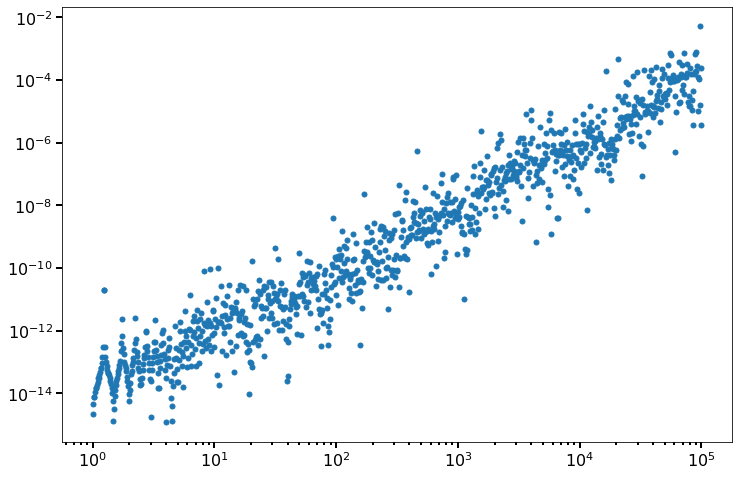

In [4]:
fig, ax = plt.subplots(figsize=(12,8))
ax.loglog(times, np.abs((x-xWH)/x), '.')

# The real time in the WH integration is the number of steps done * sim.dt

We can compare that to sim.t which accumulates error from doing += dt every timestep

In [5]:
%%time
Nout = 1000
tmax = 300
simKD = makesim()
simKD.dt = simKD.particles[1].P*np.sqrt(3)/100.
simKD.integrator="whfast"

times = np.logspace(0, np.log10(tmax), Nout)
Nsteps, simt = np.zeros(Nout), np.zeros(Nout)
for i, time in enumerate(times):
    simKD.integrate(time, exact_finish_time=0)
    Nsteps[i] = simKD.steps_done
    simt[i] = simKD.t

CPU times: user 22 ms, sys: 4.01 ms, total: 26 ms
Wall time: 23.6 ms


# Error is linear

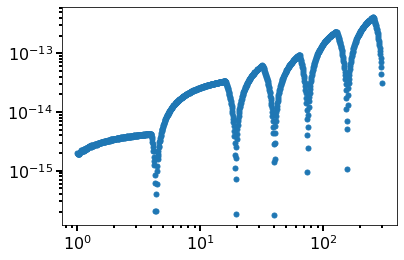

In [6]:
fig, ax = plt.subplots()
ax.loglog(times, np.abs(Nsteps*simKD.dt-simt)/simt, '.')

# Right Way

Integrate IAS15 to simWH.steps_done x simWH.dt, which is the exact time. If you care about the exact times, you could store times[i] = simKD.steps_done x simKD.dt

In [7]:
Nout = 1000
tmax = 1e5
simKD = makesim()
simKD.dt = simKD.particles[1].P*np.sqrt(3)/100.
simKD.integrator="whfast"

sim = makesim()
sim.integrator = "ias15"

times = np.logspace(0, np.log10(tmax), Nout)
xWH, x = np.zeros(Nout), np.zeros(Nout)
for i, time in enumerate(times):
    simKD.integrate(time, exact_finish_time = 0)
    sim.integrate(simKD.steps_done*simKD.dt)
    xWH[i] = simKD.particles[1].x
    x[i] = sim.particles[1].x

# Now x (a phase related quantity) grows as t^3/2 as expected from an integrated quantity derived from an action that's growing as t^1/2

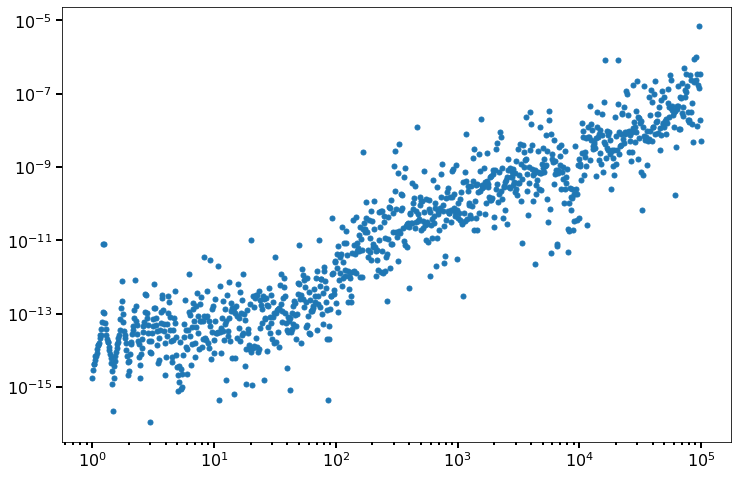

In [8]:
fig, ax = plt.subplots(figsize=(12,8))
ax.loglog(times, np.abs((x-xWH)/x), '.')